In [1]:
%pylab inline

import numpy as np
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Introduction 

AlphaZero를 구현하기 위해서 정리한 문서입니다. <br>
아래는 AlphaZero의 특징입니다.

* Paper의 이름은 [Mastering Chess and Shogi by Self-Play with a General Reinforcement Learning Algorithm](https://arxiv.org/pdf/1712.01815.pdf)
* AlphaGoZero는 바둑만 되었는데, AlphaZero부터는 일반화된 모델을 제시하면서 페이퍼에서는 체스 그리고 일본 장기까지 섭렵하게 됨. (그래서 AlphaGoZero 에서 Go가 빠진 AlphaZero가 된듯함)
* Self-play reinforcement learning 으로서 Neural Network와 Monte Carlo Tree Search를 policy interation framework안에서 합친 알고리즘
* 사람의 domain knowledge없이 게임 방식만 알려주고 문제를 풀수있다. 
* 기존 방식보다 더 심플해졌다

# Monte Carlo Tree Search

![Demo](images/demo.gif)
<center>위의 데모는 MCTS를 사용해서 OpenAI의 택시 문제를 해결하였습니다.<br> 코드: https://github.com/AndersonJo/montecarlo-tree-search</center>

AlphaZero에서는 domain knowledge를 사용하는 alpha-beta search를 사용하는 것이 아니라, Monte Carlo Tree Search (MCTS) 알고리즘을 사용하여 general-purpose model을 만들었습니다. <br>
MCTS는 다음의 특징들을 갖고 있습니다.

* Simulation: 게임을 직접 해보면서 MCTS의 트리 구조를 만든다고 보면 됩니다. 즉 게임의 완전 초기에는 root node하나만 있을 것이고, 그 다음 행동에 대한 node를 랜덤으로 action을 고르면서 트리를 확장하게 됩니다.  simulation의 마지막 즉.. 게임이 끝나는 지점에 갔을때는 이겼는지, 졌는지, 비겼는지 등등을 통해 evaluation을 하게 됩니다. (simulation 도중에는 완전한 random으로 action을 취하게 됩니다. 즉 simulation도중 몇번 게임에서 이겼다고 해당 path로만 게임을 진행하게 된다면.. 더 좋은 수나, 더 좋은 방법이 있는데 이것 찾지 못하고 끝날수 있습니다.)
* Backpropagation : simulation이 끝나면 evaluation을 한다고 했는데.. 예를 들어 게임이 종료되었을때, 마지막 leaf node에서 root node까지 방문한 기록을 하고, 이기고 졌는지에 따라서 점수를 매기게 됩니다. 즉 과거 어떤 특정 행동들이 최종 실패 또는 이기게 했는지를 점수로서 각 노드들 마다 업데이트를 하게 됩니다. 
* Upper Confidence Bound: UCT (Upper Confidence Tree)라고도 하며, MCTS의 가장 핵심이 되는 알고리즘입니다. 

$$ \mathbb{UCT}(w_i, n_i) = \frac{w_i}{n_i} + c \sqrt{ \frac{\ln t}{ n_i}}  $$

* $ \frac{w_i}{n_i} $: **exploitation component**라고 하며, winning/losing 의 비율
* $ w_i $: i번째 **자식 노드의 이긴 횟수** (number of wins)
* $ n_i $: i번째 **자식 노드의 방문 횟수** 또는 시뮬레이션 횟수 (number of simulations)
* $ \sqrt{ \frac{\ln t}{ n_i}} $: **exploration component**라고 하며, exploitation component만 사용하게 되면 오직 simulation에서 이겼던 기록이 있는 노들만 따라가기 때문에 생겨나는 문제를 해결.
* $ t $: **부모(현재) 노드의 방문 회수 또는 시뮬레이션 횟수** (number of simulations for the parent node)
* $ c $: **exploration component**의 가중치로 생각하면 되며 보통 $ \sqrt{2} $ 를 사용

exploration component의 직관적인 이해는 `방문이 상대적으로 적은 노드`를 선택하도록 유도를 하게 됩니다.<br>
예를 들어서 아래의 경우 현재 노드 (부모 노드)의 방문 t=5000 일때, 자식노드의 방문횟수에 따른 그래프는 다음과 같습니다.

[Text(0, 0.5, 'exploration'), Text(0.5, 0, 'child visit count')]

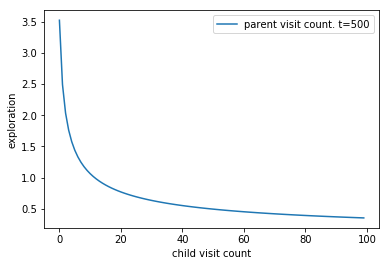

In [63]:
def exploration_component(t, x):
    c = np.sqrt(2)
    return c * np.sqrt(np.log(t) / (x+1))

x = np.arange(0, 100)
y = exploration_component(t=500, x=x)
lp = sns.lineplot(x, y, label='parent visit count. t=500')
lp.set(xlabel='child visit count', ylabel='exploration')

즉 매우 드물게 방문한 노드(액션)일수록 선택할 확률값이 올라가게 됩니다.

### 그래서 이게 AlphaZero와 뭔 상관?

도메인 지식을 알고서 만드는 alpha-beta search를 사용하는 방법이 아니라, AlphaZero는 general-purpose MCTS 알고리즘을 사용합니다. MCTS처럼 self-play를 하면서 simulation을 하게 됩니다. 각각의 simulation마다 action에 대한 선택은, 적게 방문하고 (low visit count), 높은 이동 확률 (high move probability), 그리고 높은 이기는 가치 (어떤 action을 했을때 해당 노드에서 계속 따라가서 최종 마지막 노드들에서의 평균값. averaged over the leaf states of simulations that selected a from s)를 갖는 액션을 뉴럴 네트워크를 통해서 선택하게 됩니다.

그래서 최종적으로 search가 끝나게 되면 vector 형태로 각 action (or move)에 대한 확률 분포를 나타내는 $ \boldsymbol{\pi} $ 를 리턴시키게 됩니다.

# Alpha Zero

## Neural Network



AlphaZero는 기존의 handcrafted evaluation function대신에 deep neural network를 사용합니다.

$$ (\mathbf{p}, v) = f_{\theta}(s) $$

* parameter $ \theta $ 를 사용 
* 게임 보드의 상태값인 $ s $ 를 deep neural network의 input값으로 사용
* outputs (2개)
  * $ \mathbf{p} $: a vector of move probabilities
    * 가능한 모든 actions들에 대한 vector라고 보면 됨
    * 각각의 요소들 (components)은 action을 나타냄 $ p_a = Pr(a | s) $
  * $ v $ : scalar value (continuous value)
    * state가 주어졌을때 게임을 이길지 질지에 대한 기대치
    * board state에 대해서 게임 결과에 대한 기대치 (expected outcome) $ z $ 를 구함
    * $ v_{\theta}(s) \in [-1, 1] $ 그리고 $ v \sim \mathbb{E}[z|s] $ 
* action probabilities 그리고 가치 평가 (value estimates)을 self-play로 학습을 함  
  
  
위에서 이야기 했듯이 MCTS의 search가 끝나게 되면 어떤 액션을 취해야 이길지 확률분포를 갖은 벡터 $ \mathbf{\pi} $ 를 리턴시키게 됩니다. 그리고 해당 리턴에서 가장 확률이 높은 action을 취해서 움직입니다. $ a_t \sim \mathbf{\pi}_t $<br>

## Loss Function

$$ l = (z-v)^2 - \boldsymbol{\pi}^T \log(\mathbf{p}) + c \| \theta \|^2 $$ 

* $ z $: 게임의 결과 점수
  * 이겼을때 1점
  * 비겼을때 0점
  * 졌을때 -1점
* $ v $: 게임 결과 점수 $ z $ 에 대한 예측값. 즉.. $ v_{\theta}(s_t) $
* $ (z-v) $: Neural network $ \theta $ 는 predicted outcome $ v_t $ 와 실제 게임의 결과값 (game outcome) $ z_t $의 차이를 최소화 (minimize)하도록 업데이트 됩니다.
* $ \boldsymbol{\pi}^T \log(\mathbf{p}) $: Policy vector $ \mathbf{p}_t $ 그리고 search probabilities $ \boldsymbol{\pi} $ 의 유사성을 최대화하도락 합니다. 즉 현재 state에서 어떤 action이 가장 좋은지 policy를 학습시키는 것 입니다. 다르게 써보면.. $ \boldsymbol{\pi} \cdot \log( P_{\theta} (s_t)) $
* Neural Network $ \theta $는 mean-squared error와 cross-entropy loss의 각각의 합을 loss function으로서 사용해서 gradient descent를 이용해서 학습하게 됩니다.
* $ c $: $ L_2 $ weight regularisation 에 대한 level controlling parameter. 

## Training

아래는 알파고제로와 알파제로가 다른점 입니다. <br> 
다르게 말하면 학습과정이 다르다는 뜻입니다.


1. 알파고제로는 바둑만 했기 때문에, 학습중 바둑판을 회전시키셔 data augmentation을 했지만, 알파제로는 바둑 뿐만 아니라, 체스 그리고 일본식 장기도 하여, 회전시키지 않고 학습
2. 알파고제로에서는 self-play게임을 best player와 new player와 싸움시켜서 new player가 55%이상 이기면 best player를 대체하는 방식. 알파제로에서는 하나의 뉴럴 네트워크를 그대로 사용해서 학습을 시킴. 
3. 알파고제로에서는 Bayesian optimization을 통해서 hyper-parameter tuning을 하였지만, 알파제로에서는 동일한 hyper-parameters를 갖고서 특정 게임에 튜닝하지 않고 계속 사용해서 학습

# References

* https://arxiv.org/pdf/1712.01815.pdf
* https://web.stanford.edu/~surag/posts/alphazero.html